# Memo

* 클러스터별 상품 연계 프로모션 개발을 위한, 장바구니 분석

# Set-up

In [47]:
import re
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

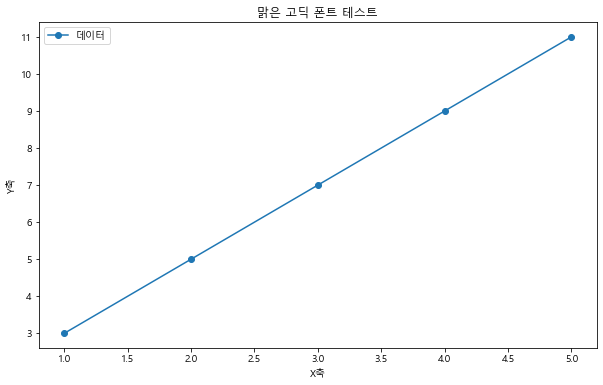

In [2]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("맑은 고딕 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [3]:
clustered_raw = pd.read_excel("./data/clustered_raw(주종+Cluster).xlsx")
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN


# 클러스터별 장바구니 분석

In [111]:
clustered_raw["New_Label"] = clustered_raw["Category3"]
clustered_raw.loc[~clustered_raw.LiquorCategory.isna(), "New_Label"] = clustered_raw.loc[~clustered_raw.LiquorCategory.isna(), "LiquorCategory"]
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory,New_Label
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN,어육제품류
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN,즉석/조리식품
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN,드레싱/소스
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN,장류
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN,장류
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN,요구르트
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN,라면류
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN,농산물통조림/병
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN,사탕류


In [115]:
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory,New_Label
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN,어육제품류
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN,즉석/조리식품
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN,드레싱/소스
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN,장류
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN,장류
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN,요구르트
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN,라면류
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN,농산물통조림/병
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN,사탕류


In [116]:
def getBasket(df, col) :
    raw_exploded = df[["OrderId", col]]
    raw_onehot = pd.get_dummies(raw_exploded, columns=[col], prefix='', prefix_sep='')
    raw_onehot = raw_onehot.groupby("OrderId").sum()
    raw_onehot = raw_onehot.clip(upper = 1)
    
    # Apriori 알고리즘을 사용하여 빈번한 항목 집합 찾기
    frequent_itemsets = apriori(raw_onehot, min_support=0.01, use_colnames=True)  # min_support는 임의로 설정한 값입니다. 필요에 따라 조정하십시오.
    # 연관 규칙 생성
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    # Lift 값으로 정렬하여 상위 규칙 확인
    rules = rules.sort_values(['lift'], ascending=False)
    
    return rules

In [123]:
liq_cats = ['고량주', '과실주', '과실주스파클링', '과실주혼성주', '기타주류', '기타주류혼성주', '기타증류주',
       '리큐르', '맥주', '맥주라이트', '민속주/전통주', '민속주/전통주차례주', '민속주/전통주혼성주', '보드카',
       '보드카혼성주', '샴페인', '소주', '소주담금주', '소주혼성주', '수입맥주', '수입맥주논알콜',
       '수입맥주혼성주', '약주', '약주차례주', '약주혼성주', '와인', '위스키', '진/럼/데킬라/아쿠아비트',
       '청주', '탁주', '탁주유산균', '탁주혼성주']

for c in range(6) :
    c_raw = clustered_raw[clustered_raw.Cluster == c]
    print("============================================")
    print(f" * 클러스터 {c}")
    rules = getBasket(c_raw, "New_Label")
    # 주류 카테고리에 포함된 항목만 필터링
    filtered_rules = rules[rules['antecedents'].apply(lambda x: any(item for item in x if item in liq_cats)) | 
                           rules['consequents'].apply(lambda x: any(item for item in x if item in liq_cats))]
    print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
    print()

 * 클러스터 0
          antecedents       consequents   support  confidence      lift
90               (맥주)            (수입맥주)  0.011244    0.146789  4.177615
91             (수입맥주)              (맥주)  0.011244    0.320000  4.177615
89               (맥주)              (소주)  0.018271    0.238532  3.085738
88               (소주)              (맥주)  0.018271    0.236364  3.085738
156  (햄/소시지(통조림/병제외))              (소주)  0.011244    0.139130  1.799842
157              (소주)  (햄/소시지(통조림/병제외))  0.011244    0.145455  1.799842
93               (맥주)             (연식품)  0.011947    0.155963  1.668690
92              (연식품)              (맥주)  0.011947    0.127820  1.668690
60              (라면류)              (소주)  0.023893    0.115254  1.490971
61               (소주)             (라면류)  0.023893    0.309091  1.490971
63             (수입맥주)             (라면류)  0.010541    0.300000  1.447119
62              (라면류)            (수입맥주)  0.010541    0.050847  1.447119
94          (즉석/조리식품)              (맥주)  0.014758    0

In [124]:
liq_cats = ['고량주', '과실주', '과실주스파클링', '과실주혼성주', '기타주류', '기타주류혼성주', '기타증류주',
       '리큐르', '맥주', '맥주라이트', '민속주/전통주', '민속주/전통주차례주', '민속주/전통주혼성주', '보드카',
       '보드카혼성주', '샴페인', '소주', '소주담금주', '소주혼성주', '수입맥주', '수입맥주논알콜',
       '수입맥주혼성주', '약주', '약주차례주', '약주혼성주', '와인', '위스키', '진/럼/데킬라/아쿠아비트',
       '청주', '탁주', '탁주유산균', '탁주혼성주']

for c in range(6):
    c_raw = clustered_raw[clustered_raw.Cluster == c]
    print("============================================")
    print(f" * 클러스터 {c}")
    
    rules = getBasket(c_raw, "New_Label")
    filtered_rules = rules[rules['antecedents'].apply(lambda x: any(item for item in x if item in liq_cats)) | 
                           rules['consequents'].apply(lambda x: any(item for item in x if item in liq_cats))]
    
    for _, row in filtered_rules.iterrows():
        antecedent = ", ".join(list(row['antecedents']))
        consequent = ", ".join(list(row['consequents']))
        
        print(f"Rule: {antecedent} => {consequent}")
        print(f"Support: {round(row['support'], 2)}")
        print(f"Confidence: {round(row['confidence'], 2)}")
        print(f"Lift: {round(row['lift'], 2)}")
        print("------------------------------------")
    print()

 * 클러스터 0
Rule: 맥주 => 수입맥주
Support: 0.01
Confidence: 0.15
Lift: 4.18
------------------------------------
Rule: 수입맥주 => 맥주
Support: 0.01
Confidence: 0.32
Lift: 4.18
------------------------------------
Rule: 맥주 => 소주
Support: 0.02
Confidence: 0.24
Lift: 3.09
------------------------------------
Rule: 소주 => 맥주
Support: 0.02
Confidence: 0.24
Lift: 3.09
------------------------------------
Rule: 햄/소시지(통조림/병제외) => 소주
Support: 0.01
Confidence: 0.14
Lift: 1.8
------------------------------------
Rule: 소주 => 햄/소시지(통조림/병제외)
Support: 0.01
Confidence: 0.15
Lift: 1.8
------------------------------------
Rule: 맥주 => 연식품
Support: 0.01
Confidence: 0.16
Lift: 1.67
------------------------------------
Rule: 연식품 => 맥주
Support: 0.01
Confidence: 0.13
Lift: 1.67
------------------------------------
Rule: 라면류 => 소주
Support: 0.02
Confidence: 0.12
Lift: 1.49
------------------------------------
Rule: 소주 => 라면류
Support: 0.02
Confidence: 0.31
Lift: 1.49
------------------------------------
Rule: 수입맥주 => 라면류
Su

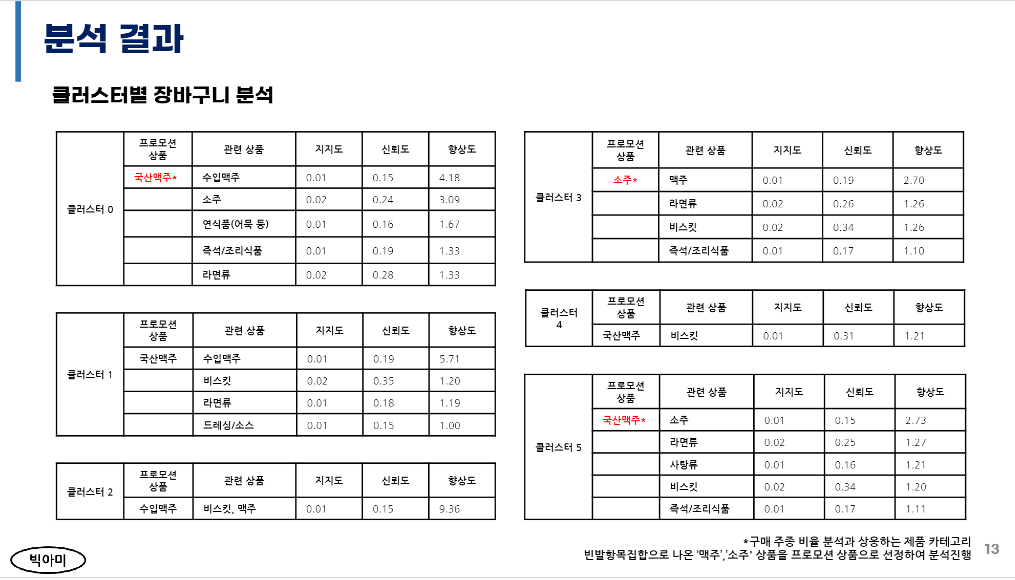